# geodetic

https://gis.stackexchange.com/questions/323317/converting-netcdf-dataset-array-to-geotiff-using-rasterio-python/329141#329141

https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python

https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html

In [1]:
import pyproj
import rasterio
from rasterio.transform import Affine
import rioxarray

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs_PlateC = ccrs.PlateCarree()

crs = pyproj.CRS.from_epsg(4326)
geod = crs.get_geod()

---
## synthetic box

In [2]:
dx, Lx = 1e3, 200*1e3
dy, Ly = 1e3, 100*1e3
ds = xr.Dataset(dict(x=np.arange(-Lx/2,Lx/2,dx), y=np.arange(-Ly/2,Ly/2,dy)))
xb, yb = xr.broadcast(ds.x, ds.y)

### Create a local projection

https://gis.stackexchange.com/questions/330746/generating-a-custom-flat-projection-in-pyproj

https://pyproj4.github.io/pyproj/stable/api/geod.html?highlight=azimuth

In [3]:
# start, end locations of a satellite track
lon0, lat0 = -40, 45
lon1, lat1 = -39, 46

# central point
lonc = (lon0+lon1)/2
latc = (lat0+lat1)/2

In [4]:
# get bearings and distance
az01,az10, dist = geod.inv(lon0, lat0, lon1, lat1)
azc1,azc0, dist = geod.inv(lonc, latc, lon1, lat1)
az01,az10, dist

(34.76040696425174, -144.52630644341738, 67837.98365835233)

In [19]:
#crs_wgs = pyproj.CRS.from_string("epsg:4326")
proj = pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")
#proj = pyproj.Proj(proj="ob_tran", p_proj="aeqd", o_alpha=45, lat_0=lat, lon_0=lon, datum="WGS84", units="m")
#proj = pyproj.Proj(proj="omerc", alpha=0, lat_0=lat0, lon_0=lon0, lonc=lon0, datum="WGS84", units="m")

xc, yc = proj.transform(lonc, latc)

x0, y0 = proj.transform(lon0, lat0)
x1, y1 = proj.transform(lon1, lat1)
x0, y0, x1, y1

(-39423.6638817209, -55445.989432279115, 38731.88730257274, 55694.10141847772)

In [20]:
# get orientation of defined by central point and point 1
#phi = -azc1
phi = np.arctan2( y1-yc, x1-xc)*180/np.pi

# build affine operators
a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
a_back = ~a_fwrd

a_fwrd*(x1,y1) , a_fwrd*(x0,y0)

((67837.98365835233, -1.4551915228366852e-11),
 (-68029.25464961569, 709.5983378324017))

In [21]:
# coordinate of the grid in projection
ds["xc"], ds["yc"] = a_back * (xb, yb)

# lon/lat coordinates
lon, lat = proj.transform(ds.xc, ds.yc, direction=pyproj.enums.TransformDirection.INVERSE)
ds["lon"] = (("x", "y"), lon)
ds["lat"] = (("x", "y"), lat)

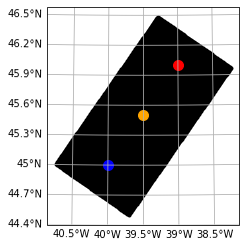

In [22]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.Orthographic(lonc, latc)))
ax.plot(ds.lon, ds.lat, ".", color="k", transform=crs_PlateC);
ax.plot(lon0, lat0, "o", ms=10, color="blue", transform=crs_PlateC)
ax.plot(lonc, latc, "o", ms=10, color="orange", transform=crs_PlateC)
ax.plot(lon1, lat1, "o", ms=10, color="red", transform=crs_PlateC)
gl = ax.gridlines(draw_labels=True, dms=False, 
             x_inline=False, y_inline=False, 
            )
gl.right_labels=False
gl.top_labels=False

In [23]:
ds = ds.rio.set_crs(proj.crs)
ds = ds.rio.set_spatial_dims("x","y")

In [24]:
import pyproj
from rasterio.transform import Affine

def lonlat2xy(lonc, latc, lon1, lat1, lon, lat):
    """ return coordinates with origin at (lonc, latc) and x-axis aligned 
    with (lonc, latc) - (lon1, lat1) direction
    
    """

    proj = pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")
    # get local coordinate
    xc, yc = proj.transform(lonc, latc)
    x1, y1 = proj.transform(lon1, lat1)
    xl, yl = proj.transform(lon, lat)
    # get orientation of defined by central point and point 1
    phi = np.arctan2( y1-yc, x1-xc)*180/np.pi
    # build affine operators
    a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
    #a_back = ~a_fwrd
    
    x, y = a_fwrd * (xl, yl)
    
    return x, y